Notebook adaptado de https://github.com/edanssandes/LicitacoesChatGPT

# Objetivo (*texto original do notebook de referência*)

Este caderno apresenta um exemplo de uso da API do ChatGPT para classificar uma série de objetos de licitação, considerando uma lista de possíveis temas. 

Ao contrário de outras abordagens, não executaremos rotinas de aprendizado supervisionado para treinar um modelo específico para cada tema. Em vez disso, o próprio chatGPT irá utilizar a sua capacidade semântica para associar cada objeto de licitação a um ou mais temas. Para melhorar a classificação, os temas podem ser melhor definidos de acordo com o interesse de cada um.

## Dependências

In [2]:
!pip install openai pandas datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dados de entrada

Reprodução do dataset do Classificacao-GPT.ipynb e Classificação-SetFit-Few-shot.ipynb

In [3]:
!wget https://github.com/thacio/Few-Shot-Editais-TI/raw/main/editais_TI.xlsx

--2023-05-09 01:19:15--  https://github.com/thacio/Few-Shot-Editais-TI/raw/main/editais_TI.xlsx
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thacio/Few-Shot-Editais-TI/main/editais_TI.xlsx [following]
--2023-05-09 01:19:15--  https://raw.githubusercontent.com/thacio/Few-Shot-Editais-TI/main/editais_TI.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702524 (686K) [application/octet-stream]
Saving to: ‘editais_TI.xlsx’

editais_TI.xlsx     100%[===================>] 686.06K  --.-KB/s    in 0.03s   

2023-05-09 01:19:16 (23.2 MB/s) - ‘editais_TI.xlsx’ saved [702524/702524]



In [4]:
import pandas
import numpy

df = pandas.read_excel('editais_TI.xlsx')
df['CLASSE_TI'] = df['CLASSE_TI'].replace({0: 'Outras compras', 1: 'Tecnologia da Informação'})
df['DES_OBJETO'] = df['DES_OBJETO'].str.replace('Objeto: Pregão Eletrônico - ', '').str.strip()
df = df[~df['DES_OBJETO'].duplicated()] # Remove colunas com objeto duplicado
df.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
0,0,153038,12019,O objeto da presente licitação é de empresa pa...,Outras compras
1,1,153054,122019,Registro de Preços para futuras aquisições de ...,Outras compras
2,2,153054,152019,Registro de preços para futuras aquisições de ...,Outras compras
3,3,153054,192019,Contratação de empresa para prestação de servi...,Outras compras
4,4,153054,332019,Registro de preço para futuras aquisições de Ó...,Outras compras


In [5]:
import pandas as pd

from sklearn.model_selection import train_test_split
df_train, df_validation = train_test_split(df, test_size=0.9408,random_state=43)

df_validation.loc[df_validation['CLASSE_TI'] == 1]
len(df_validation.loc[df_validation['CLASSE_TI'] == 1])/len(df_validation)

df_train.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
4721,4721,240104,172018,"Aquisição de Licenças de uso de Softwares, gar...",Tecnologia da Informação
3488,3488,160036,112018,Registro de preços para atender as necessidade...,Outras compras
2233,2233,153163,3522018,Registro de Preços para a eventual aquisição d...,Outras compras
5163,5163,253002,182018,Contratação de empresa especializada no fornec...,Tecnologia da Informação
863,863,120195,1652018,Contratação de serviços continuados de limpeza...,Outras compras


In [6]:
import pandas as pd
import numpy as np

# Count the number of 0s and 1s in the 'CLASSE_TI' column of the 'df_train' dataframe
num_0 = df_train['CLASSE_TI'].value_counts()[0]
num_1 = df_train['CLASSE_TI'].value_counts()[1]

# Calculate the difference between the number of 0s and 1s
diff = num_0 - num_1

# If the difference is greater than 0, randomly select that many rows from 'df_train' with label 0 and append them to 'df_validation'
if diff > 0:
    rows_to_move = df_train[df_train['CLASSE_TI'] == 'Outras compras'].sample(n=diff, random_state=42)
    df_validation = pd.concat([df_validation, rows_to_move], ignore_index=True)
    df_train = df_train.drop(rows_to_move.index)

# If the difference is less than 0, randomly select that many rows from 'df_train' with label 1 and append them to 'df_validation'
elif diff < 0:
    rows_to_move = df_train[df_train['CLASSE_TI'] == 'Tecnologia da Informação'].sample(n=-diff, random_state=42)
    df_validation = pd.concat([df_validation, rows_to_move], ignore_index=True)
    df_train = df_train.drop(rows_to_move.index)

# If the difference is already 0, do nothing
else:
    pass

In [7]:
import datasets
from datasets import load_dataset

ds_train = datasets.Dataset.from_pandas(df_train)
ds_validation = datasets.Dataset.from_pandas(df_validation)

dataset = datasets.DatasetDict({
    'train' : ds_train,
    'validation' : ds_validation
    })

In [8]:
from datasets import Dataset

# Adaptação de função do setfit para tirar amostras iguais das classes do dataframe
def sample_dataset(dataset: Dataset, label_column: str = "label", num_samples: int = 12, seed: int = 42) -> Dataset:
    """Samples a Dataset to create an equal number of samples per class (when possible)."""
    df = dataset.to_pandas()
    df = df.groupby(label_column)

    # sample num_samples, or at least as much as possible
    df = df.apply(lambda x: x.sample(min(num_samples, len(x)),random_state=seed))
    df = df.reset_index(drop=True)

    all_samples = Dataset.from_pandas(df)
    return all_samples

### Cria o dataset de few-shot

*Apenas estamos repetindo o código de criação do dataset dos outros arquivos para a geração do mesmo set de validação*

Selecionamos 8 exemplos de cada classe para o few-shot.

Para a validação, selecionaremos 50 exemplos de cada classe, para um total de 100.

In [9]:
few_shot_dataset = sample_dataset(dataset["train"], label_column="CLASSE_TI", num_samples=6,seed=42)
few_shot_dataset = few_shot_dataset.shuffle(seed=42)
eval_dataset = sample_dataset(dataset["validation"], label_column="CLASSE_TI", num_samples=50,seed=42)
eval_dataset = eval_dataset.shuffle(seed=42)
df_eval = eval_dataset.to_pandas()
objetos = df_eval['DES_OBJETO']
objetos

0     REGISTRO DE PREÇOS para prestação de serviço d...
1     Contratação de Empresa(s) Especializada(s) par...
2     Contratação de empresa especializada para forn...
3     Contratação de empresa especializada na presta...
4     Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...
                            ...                        
95    Aquisição de Cluster Upgrade - Servidor HPE Pr...
96    Contratação de empresa especializada para a pr...
97    Registro de Preços para renovação de subscriçã...
98                     Aquisição de monitores de vídeo.
99    Registro de preços para locação de veículos ut...
Name: DES_OBJETO, Length: 100, dtype: object

In [10]:
few_shot_dataset_df = few_shot_dataset.to_pandas()
few_shot_dataset_df.to_excel('few_shot_prompt.xlsx', index=False)
print('Dataset do prompt de few-shot')
few_shot_dataset_df

Dataset do prompt de few-shot


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI,__index_level_0__
0,66,20001,42018,Prestação de serviços de operação e suporte da...,Outras compras,66
1,181,201014,52019,"Aquisição de uma Solução de Gestão Jurídica, c...",Tecnologia da Informação,181
2,4466,200109,82018,Registro de preços para eventual aquisição de ...,Tecnologia da Informação,4466
3,1122,130011,82018,Contratação de serviços continuados de analise...,Tecnologia da Informação,1122
4,5619,323031,342018,Contratação de serviços continuados de apoio t...,Tecnologia da Informação,5619
5,4624,200233,82018,Registro de Preço para aquisição de ESPARGIDOR...,Outras compras,4624
6,3431,160106,572018,Registro de preço para possível aquisição de i...,Outras compras,3431
7,5217,254445,3722018,"Registro de Preços, pelo prazo de até 12 meses...",Outras compras,5217
8,3751,160166,202018,"Contratação de serviços de coleta, transporte,...",Outras compras,3751
9,4992,238014,5982018,Solução comunicação privada e corporativa com ...,Tecnologia da Informação,4992


In [11]:
print('Dataset de validação')
df_eval

Dataset de validação


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
0,2105,153164,32018,REGISTRO DE PREÇOS para prestação de serviço d...,Tecnologia da Informação
1,5687,393003,3602018,Contratação de Empresa(s) Especializada(s) par...,Outras compras
2,2150,153173,212018,Contratação de empresa especializada para forn...,Tecnologia da Informação
3,385,50001,1232018,Contratação de empresa especializada na presta...,Outras compras
4,2966,155125,32018,"Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...",Outras compras
...,...,...,...,...,...
95,5179,254420,702018,Aquisição de Cluster Upgrade - Servidor HPE Pr...,Tecnologia da Informação
96,4454,200036,52018,Contratação de empresa especializada para a pr...,Outras compras
97,4751,200100,822018,Registro de Preços para renovação de subscriçã...,Tecnologia da Informação
98,389,50001,1612018,Aquisição de monitores de vídeo.,Tecnologia da Informação


## Lista de temas

In [12]:
lista_temas = [
    'contratação refere a assuntos de tecnologia da informação e equipamentos de informática',
    'qualquer outra compra que não seja relacionada a tecnologia da informação, como escritório, obras, saúde, entre outras.',
]

# Cada um dos temas será associado a uma letra maiúscula, começando pela letra 'A'.
temas = {chr(ord('A')+i):tema for i, tema in enumerate(lista_temas)}

# Os temas serão convertidos para um formato que será lido pelo ChatGPT
temas_str = ";\n".join([f"§{k}) {v}" for k,v in temas.items()]) + "."
print(temas_str)

§A) contratação refere a assuntos de tecnologia da informação e equipamentos de informática;
§B) qualquer outra compra que não seja relacionada a tecnologia da informação, como escritório, obras, saúde, entre outras..


## Prompt do ChatGPT

Aqui teremos as instruções feitas ao ChatGPT para realizar a tarefa de classificação conforme desejamos.

In [13]:
instrucao_inicial = f"""
Logo a seguir, irei informar vários objetos de licitação, um em cada mensagem.
Cada objeto de licitação é identificado com um código, informado no início de cada mensagem, no formato "OBJ###", onde # indica um dígito. 
Classifique cada objeto de licitação apresentado de acordo com os temas apresentados abaixo, onde cada tema é identificado com um código no formato "§?", onde ? indica uma letras maiúscula:

{temas_str}
"""

In [14]:
instrucao_final = f"""
Informe agora todas as respostas em uma única mensagem no seguinte formato:
Cada linha deve apresentar o identificador do objeto, seguido do caractere ':', seguido dos identificadores dos temas mais relacionados a este objeto.
Não utilize espaços em branco dentro de cada linha, nem use espaços após o caractere ':'.
O identificador do tema deve ser mantido no memso formato "§?", onde ? indica uma letras maiúscula.
O identificador do objeto deve ser mantido no mesmo formato "OBJ###", onde # indica um dígito.
O tema relacionado deve ser apresentado pelo seu identificador.
Somente pode haver um tema por licitação. 
Apresente somente as letras associadas com o tema relacionado (exemplo de linha na resposta: "OBJ005:§A"). 
Por favor, seja conciso e utilize somente o formato solicitado. Não inclua justificativas adicionais na resposta.
"""

## Chamada à API

In [15]:
import openai

# Configuração da chave de acesso para a API
openai.api_key_path = './secret.key'

In [16]:
# retorna as mensagems que serão utilizadas no prompt do chatGPT.
def compor_mensagens(objetos_de_licitacao):
    objetos_selecionados = [
        {"role": "user", "content": f'OBJ{i:03d} {descricao}'}
        for i, descricao in objetos_de_licitacao.items()
    ]
    messagens = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": instrucao_inicial},
            {"role": "assistant", "content": "Ok. Estou pronto."}
        ] + objetos_selecionados + [
            {"role": "user", "content": instrucao_final},
        ]    
    return messagens

In [17]:
# processa a resposta do chatGPT com a classificação dos objetos
# e retorna um dicionário contendo os temas encontrados para cada objeto 
import re
def processa_resposta(resposta):
    content = resposta['choices'][0]['message']['content']
    #print(content)
    return {
        int(i):re.findall('§([A-Z])', temas)
        for i, temas in re.findall('OBJ(\d+)[\s\.-:\)]*((?:§[A-Z],?)+)', content)
    }

Mudança da temperatura para 0.0 para não haver aleatoriedade na geração (*greedy decoding*)

In [18]:
# envia o pedido de classificação ao chatGPT e retorna
import time
def classificar_chatGPT(objetos_de_licitacao):
    messagens = compor_mensagens(objetos_de_licitacao)
    resposta = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        temperature=0.0,
        messages=messagens,
    )
    time.sleep(10)
    return processa_resposta(resposta)

In [19]:
# obtemos as classificações do chatGPT, por meio de várias requisições e agrupando as licitações 
tamanho_do_grupo = min(len(objetos),10)  # obs.: o agrupamento evita estourar o limite máximo de tokens em uma requisição
respostas = {}
for grupo_de_objetos in numpy.array_split(objetos, len(objetos)/tamanho_do_grupo):
    resposta = classificar_chatGPT(grupo_de_objetos)
    respostas.update(resposta)
    print(resposta)

{0: ['A'], 1: ['B'], 2: ['A'], 3: ['B'], 4: ['B'], 5: ['B'], 6: ['A'], 7: ['B'], 8: ['A'], 9: ['A']}
{10: ['B'], 11: ['B'], 12: ['B'], 13: ['A'], 14: ['A'], 15: ['B'], 16: ['A'], 17: ['A'], 18: ['B'], 19: ['A']}
{20: ['A'], 21: ['B'], 22: ['B'], 23: ['A'], 24: ['B'], 25: ['A'], 26: ['A'], 27: ['B'], 28: ['A'], 29: ['A']}
{30: ['B'], 31: ['B'], 32: ['A'], 33: ['B'], 34: ['B'], 35: ['B'], 36: ['A'], 37: ['B'], 38: ['B'], 39: ['B']}
{40: ['A'], 41: ['B'], 42: ['A'], 43: ['B'], 44: ['A'], 45: ['B'], 46: ['A'], 47: ['A'], 48: ['B'], 49: ['B']}
{50: ['B'], 51: ['A'], 52: ['B'], 53: ['A'], 54: ['B'], 55: ['A'], 56: ['B'], 57: ['A'], 58: ['B'], 59: ['A']}
{60: ['A'], 61: ['B'], 62: ['B'], 63: ['A'], 64: ['A'], 65: ['B'], 66: ['A'], 67: ['B'], 68: ['B'], 69: ['B']}
{70: ['B'], 71: ['A'], 72: ['A'], 73: ['B'], 74: ['B'], 75: ['B'], 76: ['B'], 77: ['A'], 78: ['A'], 79: ['A']}
{80: ['B'], 81: ['B'], 82: ['A'], 83: ['B'], 84: ['A'], 85: ['B'], 86: ['B'], 87: ['A'], 88: ['A'], 89: ['A']}
{90: ['B'],

## Amostragem dos resultados

In [20]:
import random
for i, classes in sorted(random.sample(list(respostas.items()), 30)):
    print(f'OBJ{i:03d}\t' + '\x1b[1;31m' + objetos.iloc[i] +'\x1b[0m')
    for c in classes:
        print('\t\x1b[1;32m' + c +'\x1b[0m' + '\t' + temas[c])
    print('\n')

OBJ001	Contratação de Empresa(s) Especializada(s) para elaboração de seis Projetos Básicos, seis Projetos Executivos e seis Estudos Ambientais, para a Construção de Estação Hidroviária Popular   EHP nos Municípios de Casa Nova, Juazeiro, Petrolina, Pilão Arcado, Sento Sé e Sobradinho, no trecho da Hidrovia do Rio São Francisco entre Cachoeira Itaparica e Porto Real (Iguatama).
	B	qualquer outra compra que não seja relacionada a tecnologia da informação, como escritório, obras, saúde, entre outras.


OBJ003	Contratação de empresa especializada na prestação de serviços terceirizados de fotografia e revisão de texto.
	B	qualquer outra compra que não seja relacionada a tecnologia da informação, como escritório, obras, saúde, entre outras.


OBJ006	Registro de preços para a eventual contratação de serviços de lançamento e instalação de cabo de fibras ópticas e infraestrutura de rede lógica com fornecimento de material.
	A	contratação refere a assuntos de tecnologia da informação e equipamen

## Listagem de todos os resultados

In [21]:
df_eval['CLASSIFICAÇÃO_ChatGPT_zero_shot'] = ''

In [22]:
for i, classes in respostas.items():
    print(f'OBJ{i:03d}\t' + '\x1b[1;31m' + objetos.iloc[i] +'\x1b[0m')
    for c in classes:
        print('\t\x1b[1;32m' + c +'\x1b[0m' + '\t' + temas[c])
        # if c=='contratação refere a assuntos de tecnologia da informação':
        df_eval.loc[i,'CLASSIFICAÇÃO_ChatGPT_zero_shot'] = temas[c]
        if df_eval.loc[i,'CLASSIFICAÇÃO_ChatGPT_zero_shot']=='contratação refere a assuntos de tecnologia da informação e equipamentos de informática':
            df_eval.loc[i,'CLASSIFICAÇÃO_ChatGPT_zero_shot']='Tecnologia da Informação'
        else:
            df_eval.loc[i,'CLASSIFICAÇÃO_ChatGPT_zero_shot']='Outras compras'
        # else:
        #     df_eval.loc[i,'CLASSIFICAÇÃO_ChatGPT_zero_show'] = 'Outras compras'
    print('\n')

OBJ000	REGISTRO DE PREÇOS para prestação de serviço de  emissão, renovação e validação de Certificados Digitais do tipo A3, pessoa  física (e-CPF), padrão ICP - Brasil e aquisição de dispositivos de operação e  armazenamento de chaves criptográficas / Certificados Digitais - Token USB,  destinados a UFSM.
	A	contratação refere a assuntos de tecnologia da informação e equipamentos de informática


OBJ001	Contratação de Empresa(s) Especializada(s) para elaboração de seis Projetos Básicos, seis Projetos Executivos e seis Estudos Ambientais, para a Construção de Estação Hidroviária Popular   EHP nos Municípios de Casa Nova, Juazeiro, Petrolina, Pilão Arcado, Sento Sé e Sobradinho, no trecho da Hidrovia do Rio São Francisco entre Cachoeira Itaparica e Porto Real (Iguatama).
	B	qualquer outra compra que não seja relacionada a tecnologia da informação, como escritório, obras, saúde, entre outras.


OBJ002	Contratação de empresa especializada para fornecimento de atualização de licenças Autode

In [23]:
df_eval.to_excel(f'classificados_gpt_ChatGPT.xlsx', index=False)

# Calculo das métricas

## Função de cálculo das métricas

In [24]:
import evaluate
from evaluate import load

def calcular_metricas(predictions,labels):
    result = {}

    exact_match_metric = load("accuracy")
    res = exact_match_metric.compute(predictions=predictions,references=labels)
    result.update({'Accuracy': res['accuracy']})

    recall_metric = load('recall')
    res = recall_metric.compute(predictions=predictions,references=labels,pos_label=1)
    result.update({'recall_TI': res['recall']})

    precision_metric = evaluate.load("precision")
    res = precision_metric.compute(predictions=predictions,references=labels,pos_label=1)
    result.update({'precision_TI': res['precision']})

    recall_metric = load('recall')
    res = recall_metric.compute(predictions=predictions,references=labels,pos_label=0)
    result.update({'recall_outros': res['recall']})

    precision_metric = evaluate.load("precision")
    res = precision_metric.compute(predictions=predictions,references=labels,pos_label=0)
    result.update({'precision_outros': res['precision']})

    return result

In [25]:
labels = df_eval['CLASSE_TI'].tolist()
pred = df_eval['CLASSIFICAÇÃO_ChatGPT_zero_shot'].tolist()

# Troca os valores para 0 ou 1 para calculars as métricas
labels = [0 if item == 'Outras compras' else 1 for item in labels]
pred = [0 if item == 'Outras compras' else 1 for item in pred]

metricas = calcular_metricas(pred,labels)
metricas

{'Accuracy': 0.91,
 'recall_TI': 0.86,
 'precision_TI': 0.9555555555555556,
 'recall_outros': 0.96,
 'precision_outros': 0.8727272727272727}



```
ChatGPT Zero-shot
{'Accuracy': 0.91,
 'recall_TI': 0.86,
 'precision_TI': 0.9555555555555556,
 'recall_outros': 0.96,
 'precision_outros': 0.8727272727272727}
```



# Matriz de confusão

Outros Precision: 0.873
Outros Recall: 0.960
Outros F1 Score: 0.914

TI Precision: 0.956
TI Recall: 0.860
TI F1 Score: 0.905



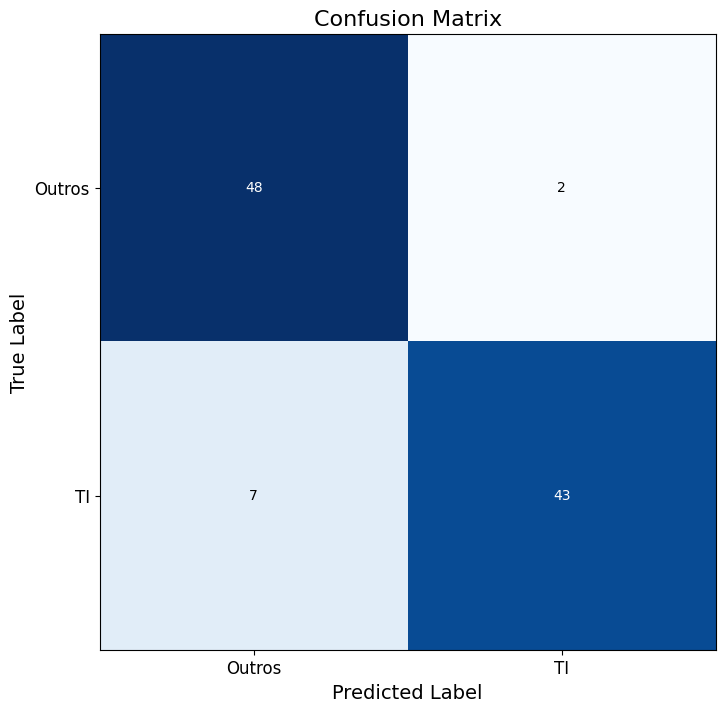

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score



# Define class labels
class_names = ['Outros', 'TI']

# Define true labels and predicted labels

# Calculate confusion matrix
cm = confusion_matrix(labels, pred)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(labels, pred, average=None)
recall = recall_score(labels, pred, average=None)
f1 = f1_score(labels, pred, average=None)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xticks([0, 1], class_names, fontsize=12)
plt.yticks([0, 1], class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Add text annotations for confusion matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
             color='white' if cm[i, j] > thresh else 'black')

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f'{class_name} Precision: {precision[i]:.3f}')
    print(f'{class_name} Recall: {recall[i]:.3f}')
    print(f'{class_name} F1 Score: {f1[i]:.3f}')
    print('')

plt.show()